In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import zscore

data = pd.read_csv('uber.csv')

data.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


In [ ]:
print("Missing values per column:\n", data.isnull().sum())

data = data.dropna()

# Convert data types if necessary (e.g., ensure numeric columns)
data = data.astype({'pickup_latitude': 'float64', 'pickup_longitude': 'float64',
                    'dropoff_latitude': 'float64', 'dropoff_longitude': 'float64', 
                    'fare_amount': 'float64'})

# Feature Engineering: Calculate distance between pickup and dropoff using Haversine formula
def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # Radius of Earth in kilometers
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    return R * 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))

data['distance_km'] = haversine_distance(data['pickup_latitude'], data['pickup_longitude'],
                                         data['dropoff_latitude'], data['dropoff_longitude'])

# Remove unrealistic distances or fares (filter out negative or zero fares and distances)
data = data[(data['distance_km'] > 0) & (data['fare_amount'] > 0)]

# Display summary of data
data.describe()

Missing values per column:
 Unnamed: 0           0
key                  0
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    1
dropoff_latitude     1
passenger_count      0
dtype: int64


,Unnamed: 0,fare_amount,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,distance_km
count,1.943470e+05,194347.000000,194347.000000,194347.000000,194347.000000,194347.000000,194347.000000,194347.000000
mean,2.770593e+07,11.356014,-73.853150,40.665377,-73.851503,40.653457,1.684842,21.372420
std,1.600804e+07,9.748423,5.965042,5.588486,8.830298,4.171816,1.388394,387.485623
min,1.000000e+00,0.010000,-1340.648410,-74.015515,-3356.666300,-881.985513,0.000000,0.000084
25%,1.382689e+07,6.000000,-73.992271,40.736347,-73.991591,40.735214,1.000000,1.281853
50%,2.773042e+07,8.500000,-73.982115,40.753250,-73.980537,40.753705,1.000000,2.184508
75%,4.153684e+07,12.500000,-73.968392,40.767507,-73.965408,40.768312,2.000000,3.960169
max,5.542357e+07,499.000000,57.418457,1644.421482,1153.572603,872.697628,208.000000,16409.239135


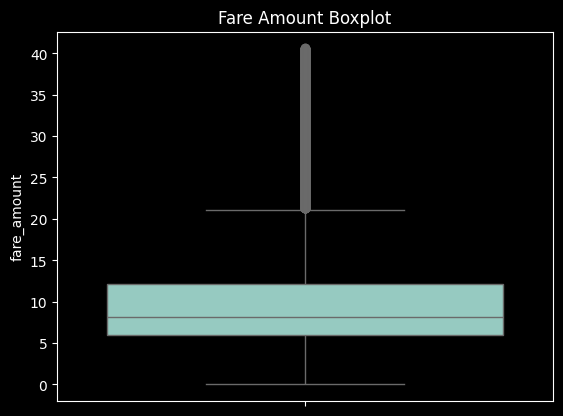

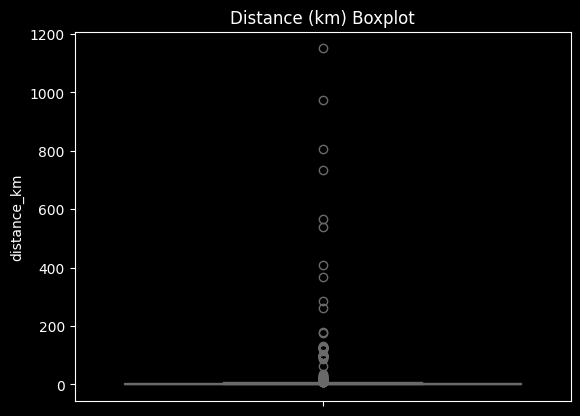

In [3]:
# Use z-score to identify outliers
z_scores = zscore(data[['fare_amount', 'distance_km']])
abs_z_scores = np.abs(z_scores)
filtered_entries = (abs_z_scores < 3).all(axis=1)  # Keep data within 3 standard deviations
data = data[filtered_entries]

# Visualize the distribution of 'fare_amount' and 'distance_km' to check for remaining outliers
sns.boxplot(data['fare_amount'])
plt.title("Fare Amount Boxplot")
plt.show()

sns.boxplot(data['distance_km'])
plt.title("Distance (km) Boxplot")
plt.show()

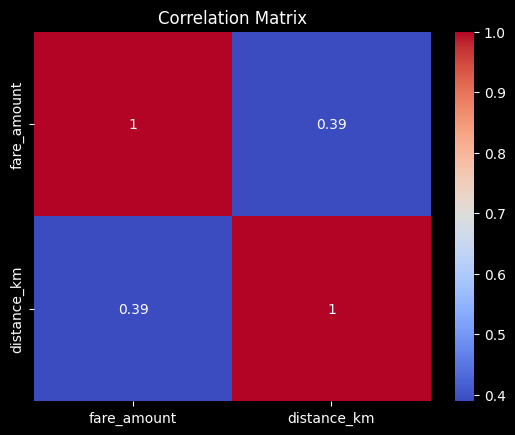

In [4]:
# Check correlation between features
correlation_matrix = data[['fare_amount', 'distance_km']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()

In [5]:
# Define features (X) and target (y)
X = data[['distance_km']]
y = data['fare_amount']

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Linear Regression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)
y_pred_linear = linear_model.predict(X_test)

# Random Forest Regression
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

In [6]:
# Function to calculate evaluation metrics
def evaluate_model(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

# Linear Regression Metrics
mse_linear, rmse_linear, r2_linear = evaluate_model(y_test, y_pred_linear)
print(f"Linear Regression - MSE: {mse_linear:.2f}, RMSE: {rmse_linear:.2f}, R2: {r2_linear:.2f}")

# Random Forest Metrics
mse_rf, rmse_rf, r2_rf = evaluate_model(y_test, y_pred_rf)
print(f"Random Forest - MSE: {mse_rf:.2f}, RMSE: {rmse_rf:.2f}, R2: {r2_rf:.2f}")

# Compare model performances
results = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest'],
    'MSE': [mse_linear, mse_rf],
    'RMSE': [rmse_linear, rmse_rf],
    'R2': [r2_linear, r2_rf]
})
print(results)

Linear Regression - MSE: 38.96, RMSE: 6.24, R2: 0.06
Random Forest - MSE: 13.71, RMSE: 3.70, R2: 0.67
               Model        MSE      RMSE        R2
0  Linear Regression  38.955520  6.241436  0.057235
1      Random Forest  13.713013  3.703109  0.668131
